# Exercise under 3.2.5

In [105]:
import numpy as np
import matplotlib.pyplot as plt

In [106]:
def theta_scheme(delta_t, delta_x, scheme = None, theta = 0):
    if scheme == 'explicit':
        theta = 0
    elif scheme == 'implicit':
        theta = 1
    elif scheme == 'CN':
        theta = 0.5

    n = np.int_(1/delta_t)  # num of time steps
    m = np.int_(1/delta_x)  # num of x steps
    sigma_squared = 0.2
    alpha = delta_t / (delta_x**2)

    U = np.zeros(shape = (m+1, n+1))
    for j in range(m+1):
        x_0 = delta_x * j
        assert ((0 <= x_0) and (x_0 <= 1))
        U[j, 0] = (x_0)**2 if x_0 <= 1/2 else (1-x_0)**2
    # U[:, 0] = 0
    # U[:, n] = 0         ## unnecessary b/c U is set by np.zeros()

    A = np.diag(-2*np.ones(shape = (m-1,)))
    for k in range(1, m-1):
        A[k, k-1] = 1
        A[k-1, k] = 1

    coef = alpha * sigma_squared / 2
    left_matrix = np.identity(m-1) - coef * theta * A
    right_matrix = np.identity(m-1) + coef * (1-theta) * A

    for i in range(1, n+1):
        U[1:-1, i] = np.linalg.inv(left_matrix) @ (right_matrix) @ U[1:-1, i-1] #omitting b_i b/c boundary set to be 0

    return U

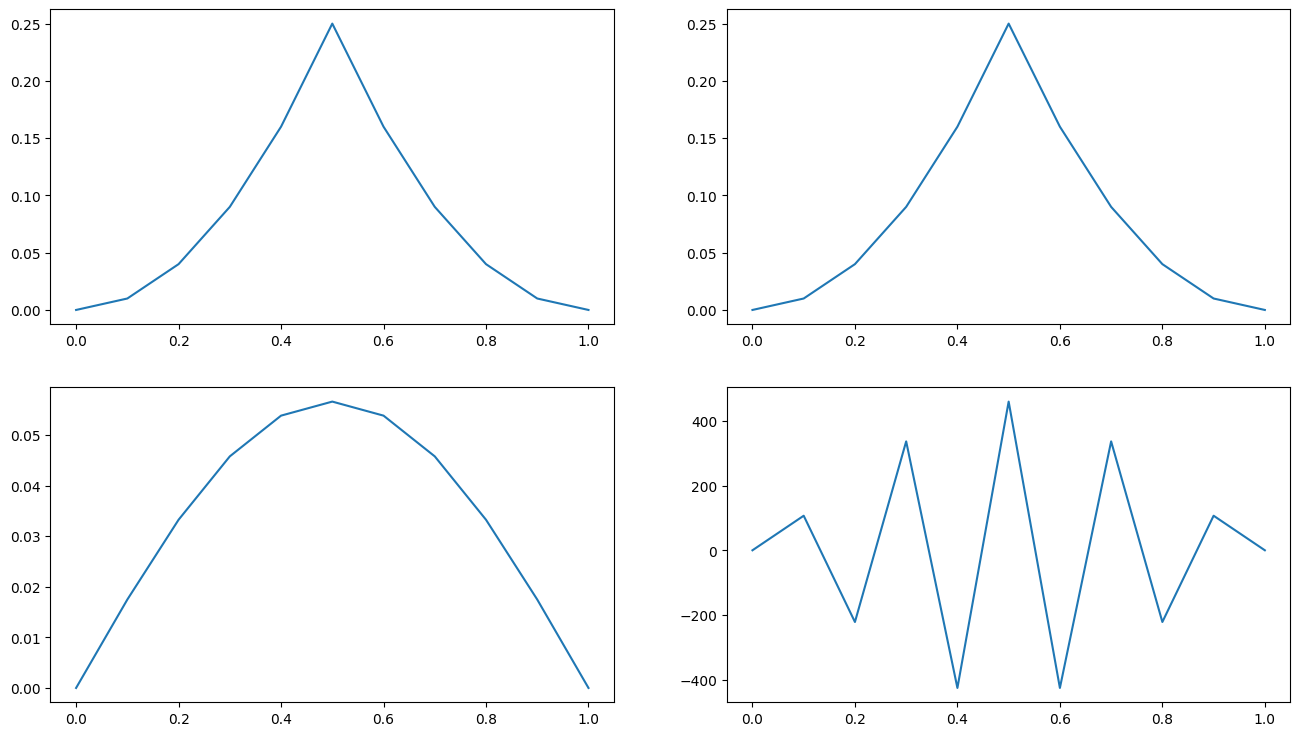

In [107]:
fig, ax = plt.subplots(2, 2, figsize = (16, 9))

x_range = np.arange(0, 1.1, 0.1)
U1 = theta_scheme(delta_t = 0.001, delta_x = 0.1, scheme = 'explicit')
U2 = theta_scheme(delta_t = 0.1, delta_x = 0.1, scheme = 'explicit')

ax[0][0].plot(x_range, U1[:, 0])
ax[1][0].plot(x_range, U1[:, -1])
ax[0][1].plot(x_range, U2[:, 0])
ax[1][1].plot(x_range, U2[:, -1])

plt.show()

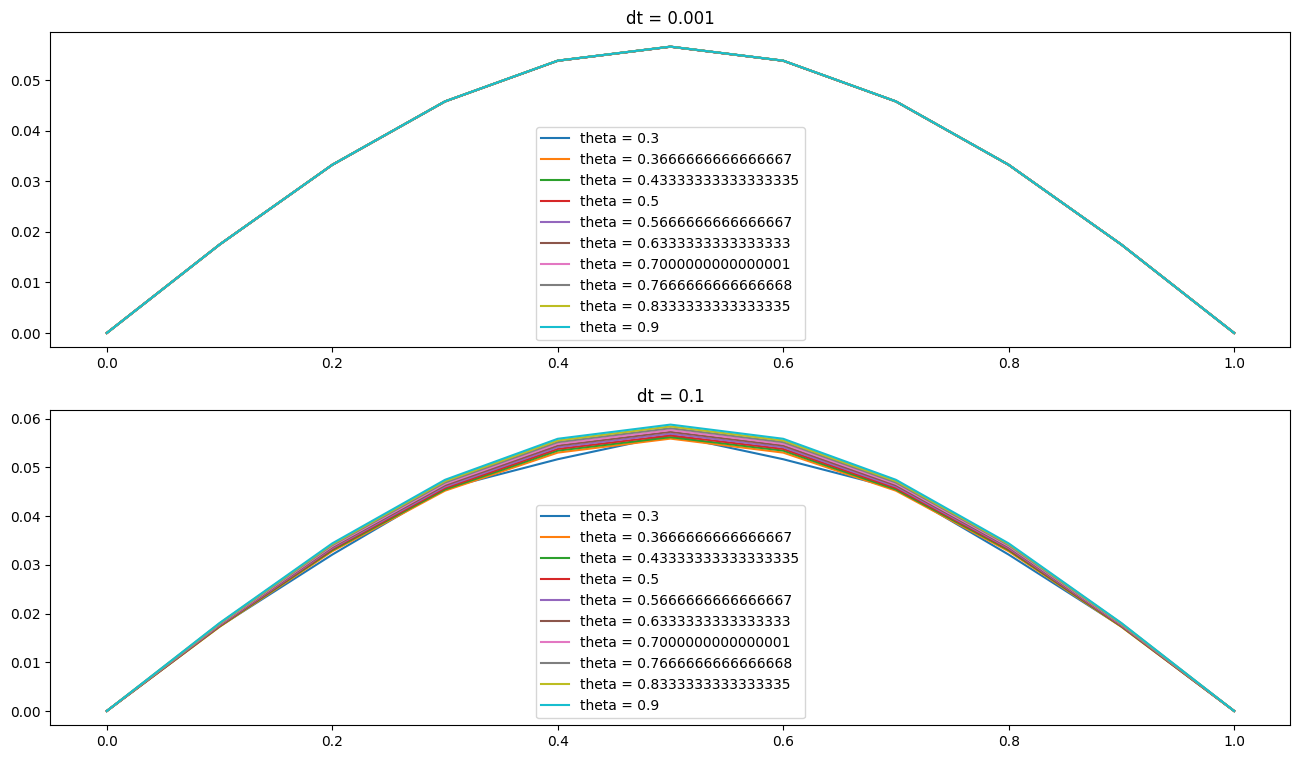

In [112]:
fig, ax = plt.subplots(2, figsize = (16, 9))
thetas = np.linspace(0.3, 0.9, 10)
x_range = np.arange(0, 1.1, 0.1)

for theta in thetas:
    U1 = theta_scheme(delta_t = 0.001, delta_x = 0.1, theta = theta)
    U2 = theta_scheme(delta_t = 0.1, delta_x = 0.1, theta = theta)
    ax[0].plot(x_range, U1[:, -1], label = f'theta = {theta}')
    ax[1].plot(x_range, U2[:, -1], label = f'theta = {theta}')
    ax[0].set_title('dt = 0.001')
    ax[1].set_title('dt = 0.1')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
plt.show()

From the plots we can see that instability is not present for $\theta > 0.5$


# Exercise 11

In [75]:
import numpy as np
from tqdm import tqdm
import scipy.linalg
from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.stats import norm
import matplotlib.pyplot as plt

In [94]:
def BS_theta_scheme(r=0, sig=0.25, S0=100, K=90, T=1, theta=0.5, isCall=True, isEuropean=True, Nspace=1000, Ntime=2000):
    X0 = np.log(S0)
    S_max = S0 * np.exp(1)
    S_min = S0 * np.exp(-2)
    x_max = np.log(S_max)
    x_min = np.log(S_min)
    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)
    t, dt = np.linspace(0, T, Ntime, retstep=True)

    Payoff = np.maximum(np.exp(x)-K, 0) if isCall else np.maximum(K - np.exp(x), 0)
    V = np.zeros((Nspace, Ntime))
    offset = np.zeros(Nspace - 2)
    V[:, -1] = Payoff
    if isCall:
        V[-1, :] = S_max - K * np.exp(-r * t[::-1])
        V[0, :] = 0
    else:
        V[-1, :] = 0
        V[0, :] = K * np.exp(-r * t[::-1]) - S_min

    # Tridiagonal matrix
    sig2 = sig * sig
    dxx = dx * dx
    a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    a1 = (theta * dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    b1 = 1 + theta * dt * (sig2 / dxx + r)
    c1 = -(theta * dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    lhs = sparse.diags([a1, b1, c1], [-1, 0, 1], shape=(Nspace - 2, Nspace -2)).tocsc()
    a2 = -(1 - theta) * (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    b2 = 1 - (1 - theta) * dt * (sig2 / dxx + r)
    c2 = (1 - theta) * (dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    rhs = sparse.diags([a2, b2, c2], [-1, 0, 1], shape=(Nspace - 2, Nspace -2)).tocsc()

    # Backward iteration for finite difference
    for i in range(Ntime - 2, -1, -1):
        offset[0] = a * V[0, i]
        offset[-1] = c * V[-1, i]
        if isEuropean:
            V[1:-1, i] = spsolve(lhs, rhs @ V[1:-1, i + 1] + offset)
        else:
            V[1:-1, i] = np.maximum(spsolve(lhs, rhs @ V[1:-1, i + 1] + offset), Payoff[1:-1])

    Price = np.interp(X0, x, V[:, 0])
    return Price

## Bermudan Put has more value than European Put

100%|██████████| 41/41 [09:51<00:00, 14.43s/it]


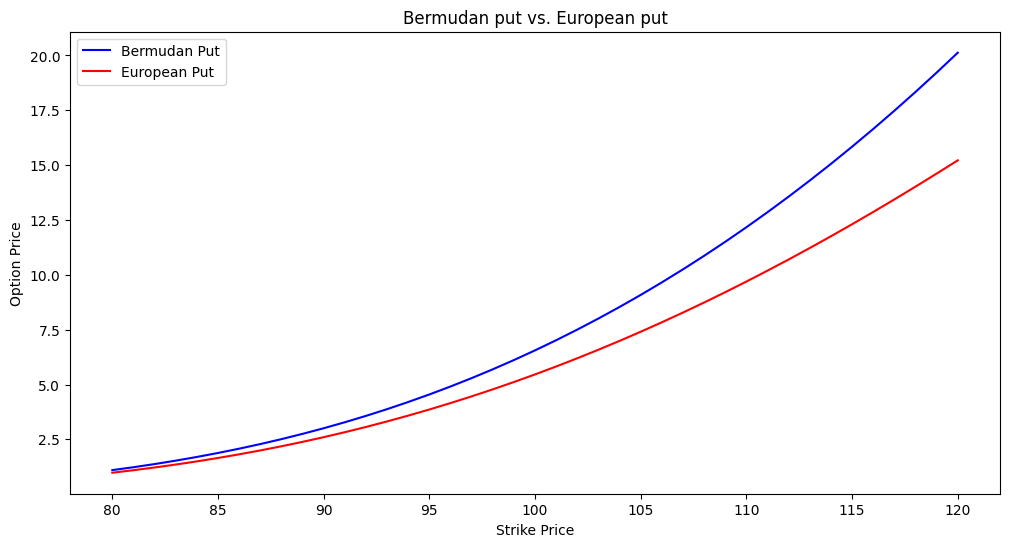

In [104]:
Ks = range(80, 121)
bop = []
eop = []
for K in tqdm(Ks):
    bop.append(BS_theta_scheme(r=0.1, K = K, isCall=False, isEuropean=False))
    eop.append(BS_theta_scheme(r=0.1, K = K, isCall=False, isEuropean=True))

plt.figure(figsize=(12, 6))
plt.plot(Ks, bop, color="blue", label="Bermudan Put")
plt.plot(Ks, eop, color="red", label="European Put")

plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Bermudan put vs. European put")
plt.legend()
plt.show()

## Tree Function

In [85]:
# Black-Scholes formula for European option
def black_scholes(S0=100, K=90, T=1, r=0.1, sigma=0.25, Call = True):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign_ = 1 if Call else -1
    price = sign_ * (S0 * norm.cdf(sign_*d1) - K * np.exp(-r * T) * norm.cdf(sign_*d2))
    delta = sign_ * norm.cdf(sign_*d1)
    gamma = norm.pdf(d1)/(S0*sigma*np.sqrt(T))
    return price

# Binomial Tree
def binomial_tree(S0=100, K=90, T=1, r=0.1, sigma=0.25, n=1000, Call = True, European = True):
    sign_ = 1 if Call else -1
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    df = np.exp(-r * dt)

    C = np.zeros((n+1, n+1))

    for i in range(n+1):
        C[i, n] = max(0, sign_ * (S0 * u**i * d**(n-i) - K))

    for j in range(n-1, -1, -1):
        for i in range(j+1):
            if European:
                C[i, j] = df * (p * C[i+1, j+1] + (1-p) * C[i, j+1])
            else:
                C[i, j] = np.maximum((sign_ * (S0 * u ** i * d ** (j-i) - K)),
                                     df * (p * C[i+1, j+1] + (1-p) * C[i, j+1]))
    price = C[0, 0]
    gamma = ((C[2, 2] - C[1, 2]) / (S0 * u ** 2 - S0 * u * d) - (C[1, 2] - C[0, 2]) / (S0 * u * d - S0 * d ** 2)) / (0.5 * (S0 * u ** 2 - S0 * d ** 2))
    delta = (C[1, 1] - C[0, 1]) / (S0 * u - S0 * d)
    return C[0, 0]

def trinomial_tree(S0=100, K=90, T=1, r=0.1, sigma=0.25, n=1000, lam=1.5, isCall = True, isEuropean = True):
    sign_ = 1 if isCall else -1
    dt = T / n
    u = np.exp(lam * sigma * np.sqrt(dt))
    d = np.exp(-lam * sigma * np.sqrt(dt))
    m = 1.0
    pu = 1/(2*lam**2) + (r - 0.5*sigma**2)/(2*lam*sigma) * np.sqrt(dt)
    pd = 1/(2*lam**2) - (r - 0.5*sigma**2)/(2*lam*sigma) * np.sqrt(dt)
    pm = 1 - pu - pd
    df = np.exp(-r * dt)

    # Initialize the end nodes of the tree with option values
    values = np.zeros((2*n+1, n+1))
    for i in range(2*n+1):
        S = S0 * (u**(max(i-n, 0))) * (d**(max(n-i, 0)))
        values[i, n] = max(sign_*(S - K), 0)

    # Backward induction for option value
    for j in range(n-1, -1, -1):
        for i in range(0, 2*j+1):
            p = df * (pu * values[i+2, j+1] + pm * values[i+1, j+1] + pd * values[i, j+1])
            if isEuropean:
                values[i, j] = p
            else:
                S = S0 * (u**(max(i-j, 0))) * (d**(max(j-i, 0)))
                exercise_val = max(sign_*(S - K), 0)
                values[i, j] = max(p, exercise_val)

    return values[0, 0]

## Convergence along time partition

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


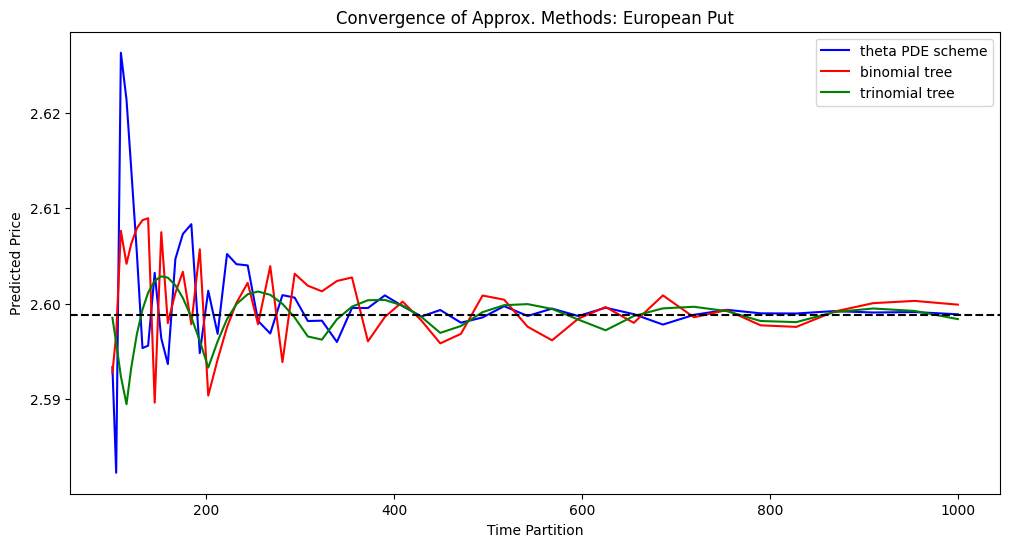

In [95]:
ts = np.logspace(2, 3, 50).astype(np.int_)
theta_PDE = []
binomial = []
trinomial = []
bs_price = black_scholes(r=0.1, Call = False)
for t in tqdm(ts):
    theta_PDE.append(BS_theta_scheme(r=0.1, isCall=False, isEuropean=True, Nspace=t//2, Ntime=t))
    binomial.append(binomial_tree(r=0.1, n=t, Call = False, European = True))
    trinomial.append(trinomial_tree(r=0.1, n=t, isCall = False, isEuropean = True))

plt.figure(figsize=(12, 6))
plt.plot(ts, theta_PDE, color="blue", label="theta PDE scheme")
plt.plot(ts, binomial, color="red", label="binomial tree")
plt.plot(ts, trinomial, color="green", label="trinomial tree")
plt.axhline(bs_price, color='black',linestyle='--')

plt.xlabel("Time Partition")
plt.ylabel("Predicted Price")
plt.title("Convergence of Approx. Methods: European Put")
plt.legend()
plt.show()

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


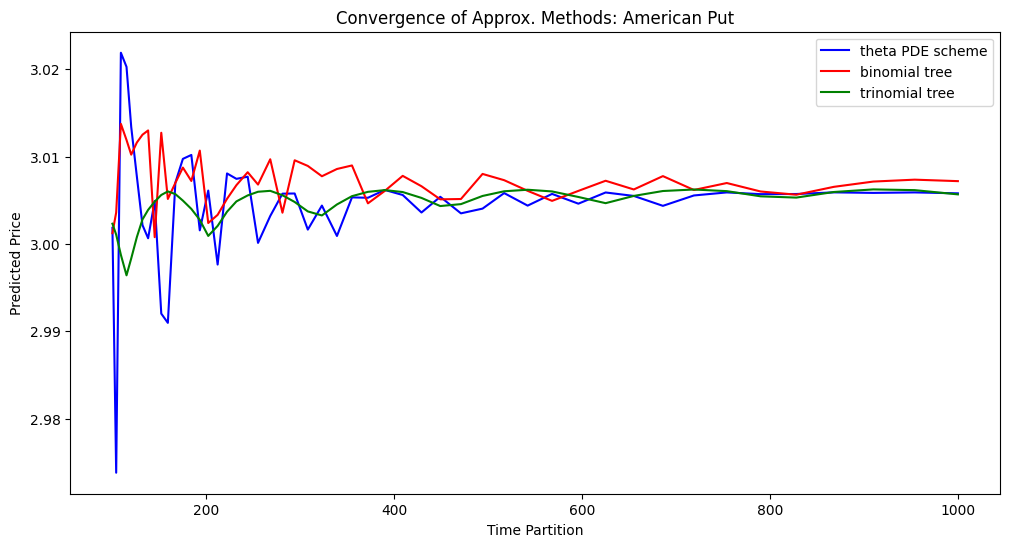

In [97]:
ts = np.logspace(2, 3, 50).astype(np.int_)
theta_PDE = []
binomial = []
trinomial = []
for t in tqdm(ts):
    theta_PDE.append(BS_theta_scheme(r=0.1, isCall=False, isEuropean=False, Nspace=t//2, Ntime=t))
    binomial.append(binomial_tree(r=0.1, n=t, Call = False, European = False))
    trinomial.append(trinomial_tree(r=0.1, n=t, isCall = False, isEuropean = False))

plt.figure(figsize=(12, 6))
plt.plot(ts, theta_PDE, color="blue", label="theta PDE scheme")
plt.plot(ts, binomial, color="red", label="binomial tree")
plt.plot(ts, trinomial, color="green", label="trinomial tree")

plt.xlabel("Time Partition")
plt.ylabel("Predicted Price")
plt.title("Convergence of Approx. Methods: American Put")
plt.legend()
plt.show()

## Computational Cost Analysis

In [99]:
from scipy.sparse.linalg import inv

def BS_theta_scheme_inv(r=0, sig=0.25, S0=100, K=90, T=1, theta=0.5, isCall=True, isEuropean=True, Nspace=1000, Ntime=2000):
    X0 = np.log(S0)
    S_max = S0 * np.exp(1)
    S_min = S0 * np.exp(-2)
    x_max = np.log(S_max)
    x_min = np.log(S_min)
    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)
    t, dt = np.linspace(0, T, Ntime, retstep=True)

    Payoff = np.maximum(np.exp(x)-K, 0) if isCall else np.maximum(K - np.exp(x), 0)
    V = np.zeros((Nspace, Ntime))
    offset = np.zeros(Nspace - 2)
    V[:, -1] = Payoff
    if isCall:
        V[-1, :] = S_max - K * np.exp(-r * t[::-1])
        V[0, :] = 0
    else:
        V[-1, :] = 0
        V[0, :] = K * np.exp(-r * t[::-1]) - S_min

    # Tridiagonal matrix
    sig2 = sig * sig
    dxx = dx * dx
    a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    a1 = (theta * dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    b1 = 1 + theta * dt * (sig2 / dxx + r)
    c1 = -(theta * dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    lhs = sparse.diags([a1, b1, c1], [-1, 0, 1], shape=(Nspace - 2, Nspace -2)).tocsc()
    a2 = -(1 - theta) * (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    b2 = 1 - (1 - theta) * dt * (sig2 / dxx + r)
    c2 = (1 - theta) * (dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
    rhs = sparse.diags([a2, b2, c2], [-1, 0, 1], shape=(Nspace - 2, Nspace -2)).tocsc()
    lhsinv = inv(lhs)

    # Backward iteration for finite difference
    for i in range(Ntime - 2, -1, -1):
        offset[0] = a * V[0, i]
        offset[-1] = c * V[-1, i]
        if isEuropean:
            V[1:-1, i] = lhsinv @ (rhs @ V[1:-1,i+1] + offset)
        else:
            V[1:-1, i] = np.maximum(lhsinv @ (rhs @ V[1:-1,i+1] + offset), Payoff[1:-1])

    Price = np.interp(X0, x, V[:, 0])
    return Price

In [103]:
import time

start_time = time.time()
print(BS_theta_scheme(r=0.1, isCall=False, isEuropean=True, Nspace=1000, Ntime=2000))
end_time = time.time()
diff = end_time - start_time
print(f"Time w/ spsolve: {diff}")

start_time = time.time()
print(BS_theta_scheme_inv(r=0.1, isCall=False, isEuropean=True, Nspace=1000, Ntime=2000))
end_time = time.time()
diff = end_time - start_time
print(f"Time w/ inv: {diff}")

2.598740700259768
Time w/ spsolve: 8.395817518234253
2.598740700259768
Time w/ inv: 6.7993292808532715


From the elapsed times, we can see that using matrix inversion is more efficient than using spsolve.